C:\Users\adop\AppData\Local\Temp\ipykernel_7708\3570941394.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(x[:100], use_line_collection=True)  # Plot a subset of the sequence for visibility


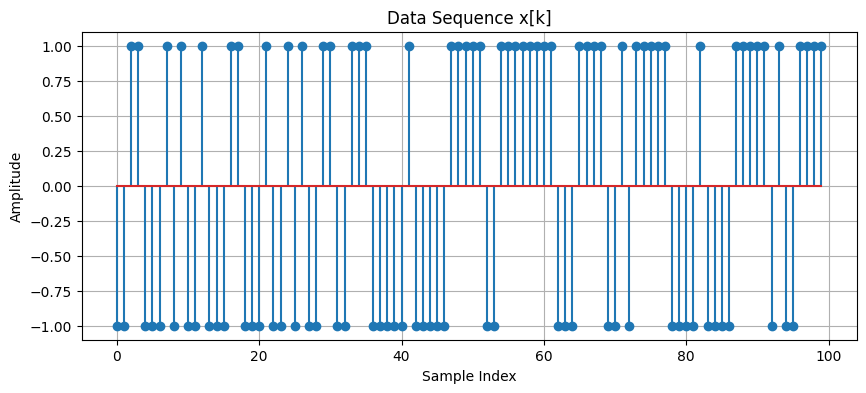

array([-1, -1,  1,  1, -1, -1, -1,  1, -1,  1])

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate the data sequence
L = 10000  # Length of data sequence
x = np.random.choice([-1, 1], size=L)  # Generate +1 and -1 uniformly

# Plot the data sequence
plt.figure(figsize=(10, 4))
plt.stem(x[:100], use_line_collection=True)  # Plot a subset of the sequence for visibility
plt.title("Data Sequence x[k]")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

x[:10]

C:\Users\adop\AppData\Local\Temp\ipykernel_7708\4110298432.py:9: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(h, use_line_collection=True)


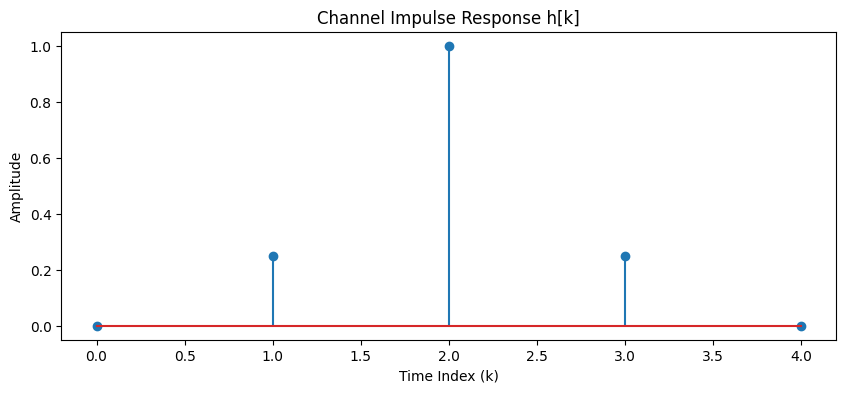

In [7]:
# Define h[k]
W = 3
h = np.zeros(5)  # Initialize h[k] with zeros (k = 0 to 4)
for k in range(1, 4):  # k = 1, 2, 3
    h[k] = 0.5 * (1 + np.cos((2 * np.pi / W) * (k - 2)))

# Plot h[k]
plt.figure(figsize=(10, 4))
plt.stem(h, use_line_collection=True)
plt.title('Channel Impulse Response h[k]')
plt.xlabel('Time Index (k)')
plt.ylabel('Amplitude')
plt.show()

C:\Users\adop\AppData\Local\Temp\ipykernel_7708\3631959181.py:17: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y[:200], use_line_collection=True)  # Plot a subset of the channel output for visibility


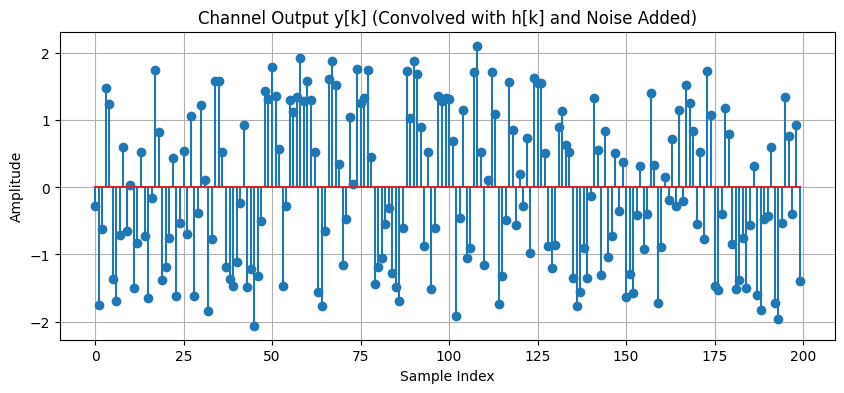

In [8]:
# Step 2: Define the raised cosine filter (channel impulse response)
def raised_cosine(k, W):
    if k in [1, 2, 3]:
        return 0.5 * (1 + np.cos((2 * np.pi / W) * (k - 2)))
    return 0

W = 3.5 # Channel distortion parameter
h = np.array([raised_cosine(k, W) for k in range(3)])  # Create h[k] for k=1,2,3 (rest are 0)

# Perform convolution and add Gaussian noise
noise_variance = 0.1
n = np.random.normal(0, np.sqrt(noise_variance), size=L)  # Gaussian noise
y = np.convolve(x, h, mode='same') + n  # Convolve x with h[k] and add noise

# Plot the channel output
plt.figure(figsize=(10, 4))
plt.stem(y[:200], use_line_collection=True)  # Plot a subset of the channel output for visibility
plt.title("Channel Output y[k] (Convolved with h[k] and Noise Added)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

taps is the weights or memory of the equalizer. How many past values of the received signal y[k] the equalizer consider at each step to estimate x[k].

[ 0.          0.          0.         ... -0.43078736  1.02625543
  0.61245775]


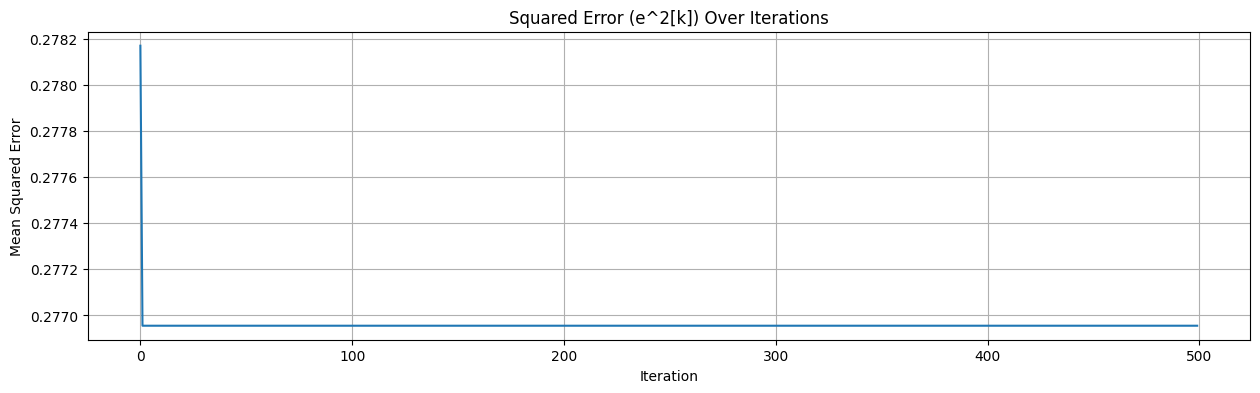

(array([-0.00937722, -0.03912848,  0.05974574, -0.10658084,  0.11950831,
        -0.25580908,  0.83557276, -0.00834025,  0.06926374,  0.15442842,
        -0.14942436]),
 array([ 0,  0,  0,  0,  0,  0,  0, -2,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, -1,  0,  1,  1,  0,  0, -1,  0, -1]))

In [9]:
# Step 3: Implement Linear Adaptive Equalizer
def linear_adaptive_equalizer(y, x, M=11, eta=0.075, max_iter=700, delay=7):
    """
    Linear adaptive equalizer using gradient descent.
    
    Parameters:
    y: Channel output
    x: Original data sequence
    M: Number of taps in the equalizer
    eta: Learning rate
    max_iter: Maximum number of iterations
    delay: Delay to align equalizer output with input
    
    Returns:
    weights: Final equalizer weights
    e2: Squared error over iterations
    equalized_output: Equalized signal after convergence
    """
    # Initialize weights and error
    weights = np.zeros(M) #initialize weights to zero
    e2 = []  # error
    equalized_output = np.zeros_like(x) #initialize equalized output

    # Pad the input to handle equalizer taps
    y_padded = np.pad(y, (M - 1, 0), 'constant')
    print(y_padded)
        
    for _ in range(max_iter):
        total_error = 0
        for k in range(len(x) - abs(delay)-M+1):
            # Extract M-tap window from channel output
            y_tap = y_padded[k:k + M][::-1]  # Reverse for convolution-like operation

            if len(y_tap) != M:
                continue
            
            # Compute equalizer output
            x_hat = np.dot(weights, y_tap)
            equalized_output[k] = x_hat

            if delay >= 0:
                error = x_hat - x[k + delay]  # Positive delay
            else:
                error = x_hat - x[k - abs(delay)] 
            
            # Update weights using gradient descent
            weights -= eta * error * y_tap
            
            # Accumulate squared error
            total_error += error**2

        # Store mean squared error for this iteration
        e2.append(total_error / len(x))

    return weights, e2, equalized_output

# Parameters for the equalizer
M = 11
eta = 0.075
max_iter = 500
delay = -7

# Run the linear adaptive equalizer
weights, e2, equalized_output = linear_adaptive_equalizer(y, x, M, eta, max_iter, delay)
equalized_output_shifted = np.roll(equalized_output, -abs(delay))

# Plot the squared error over iterations
plt.figure(figsize=(15, 4))
plt.plot(e2)
plt.title("Squared Error (e^2[k]) Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

equalized_output_quantized = np.where(equalized_output_shifted >= 0, 1, -1)

# Return final weights and first few equalized outputs
weights, equalized_output[:30]

In [10]:
# Compute cross-correlation between x and equalized_output
cross_corr = np.correlate(x, equalized_output_quantized, mode='full')

# Find the delay D that maximizes the cross-correlation
delay = np.argmax(cross_corr) - len(x) + 1

print(f'Optimal Delay: {delay}')

Optimal Delay: 0


In [11]:
# Compare the quantized output with the original signal
num_errors = np.sum(x != equalized_output_quantized)
ber = num_errors / len(x)

print(f'Number of Errors: {num_errors}')
print(f'Bit Error Rate (BER): {ber}')

Number of Errors: 2964
Bit Error Rate (BER): 0.2964


In [12]:
print(eta)
print(max_iter)
print(W)
print(noise_variance)
print(ber)

0.075
500
3.5
0.1
0.2964


C:\Users\adop\AppData\Local\Temp\ipykernel_7708\919358974.py:11: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(x[:100], label="Original signal", linefmt="r-", markerfmt="bo", use_line_collection=True)


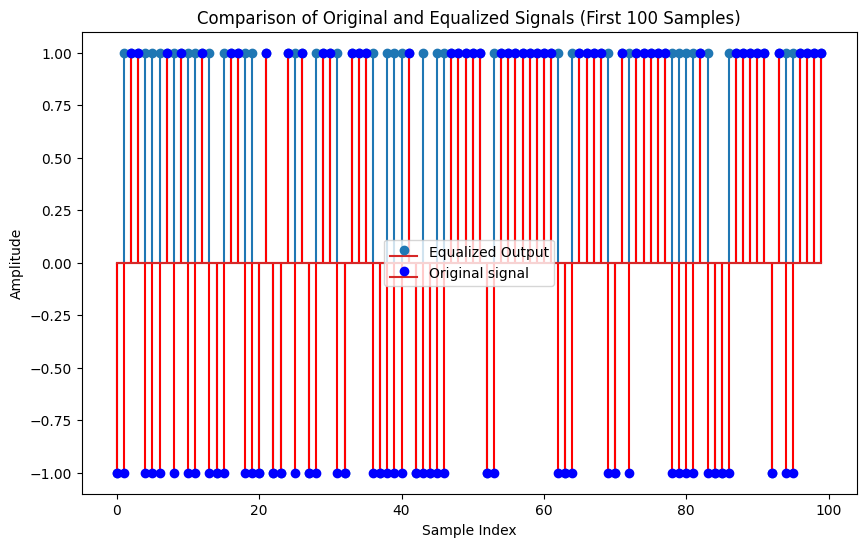

In [16]:
# Plot original vs equalized signals (first 100 samples)
plt.figure(figsize=(10, 6))
plt.stem(equalized_output_quantized[:100], label="Equalized Output")
plt.legend()
plt.title("Comparison of Original and Equalized Signals (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()

# Plot original vs equalized signals (first 100 samples)
plt.stem(x[:100], label="Original signal", linefmt="r-", markerfmt="bo", use_line_collection=True)
plt.legend()
plt.title("Comparison of Original and Equalized Signals (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

Epoch 0, Loss: 0.7306353935027333
Epoch 100, Loss: 0.024321225554954744
Epoch 200, Loss: 0.007526331064048032
Epoch 300, Loss: 0.003309189613892914
Epoch 400, Loss: 0.002218132548440287


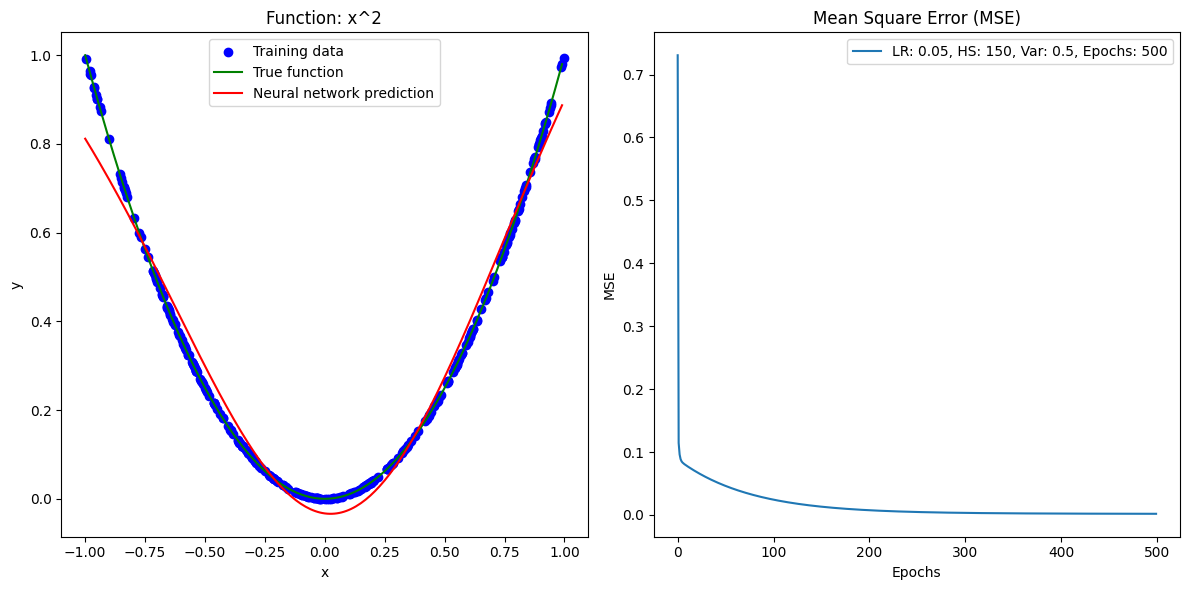

Epoch 0, Loss: 1.0851408878541238
Epoch 100, Loss: 0.010813955529475835
Epoch 200, Loss: 0.0077351550291752036
Epoch 300, Loss: 0.00555398882577898
Epoch 400, Loss: 0.004009371488644642


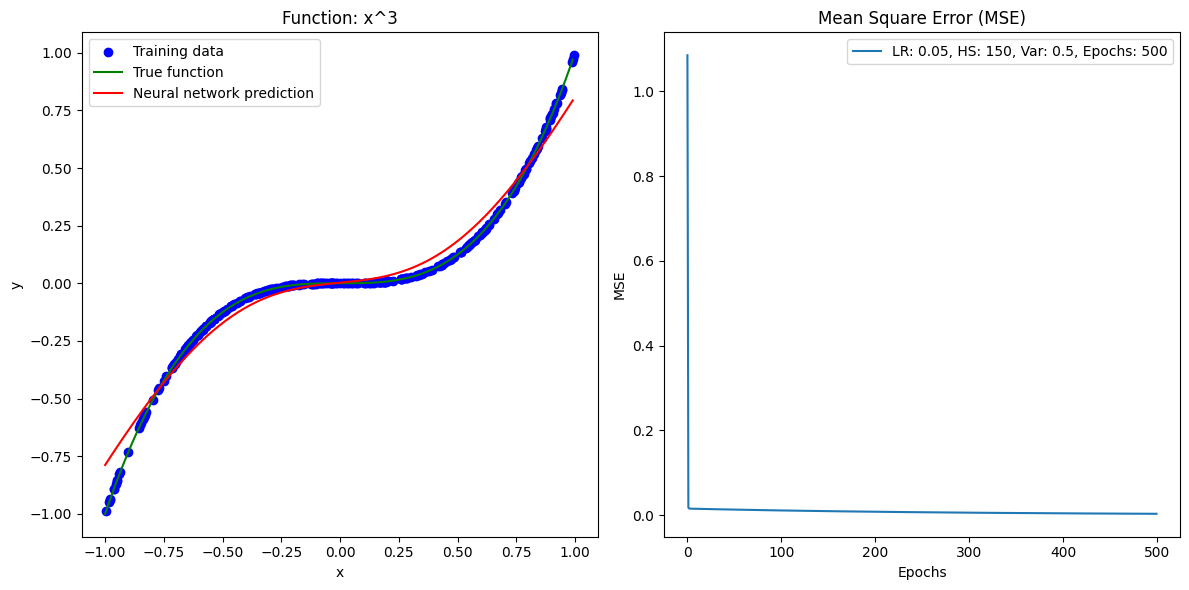

Epoch 0, Loss: 0.6562435721198534
Epoch 100, Loss: 0.4082228675861672
Epoch 200, Loss: 0.37727942533045467
Epoch 300, Loss: 0.3518994328937749
Epoch 400, Loss: 0.3306243920235601


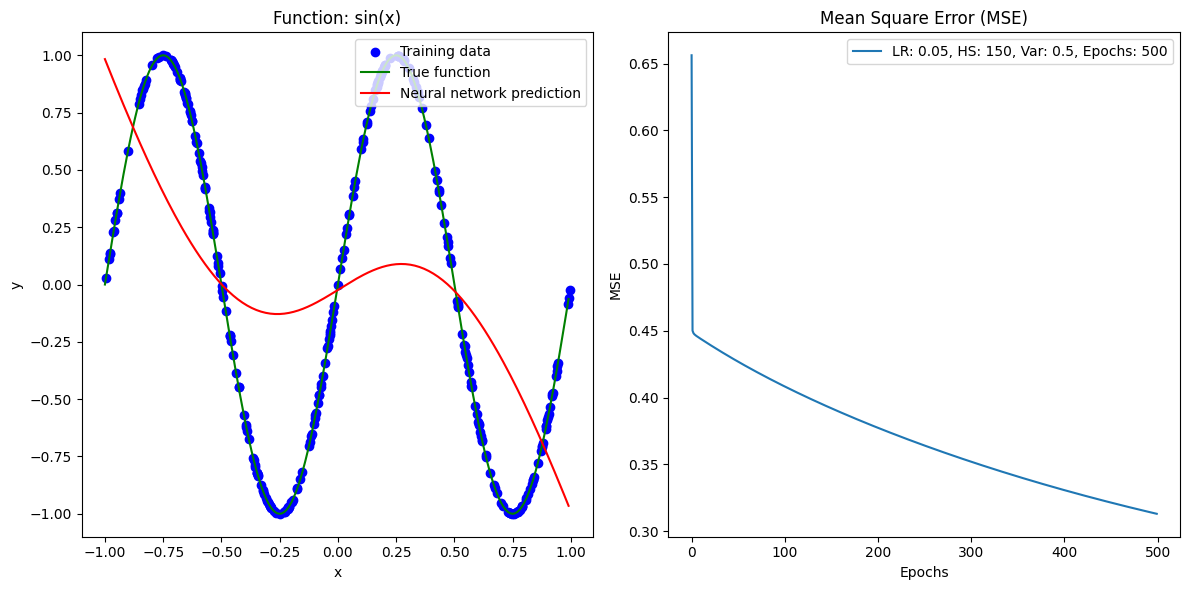

Epoch 0, Loss: 0.8499109303811324
Epoch 100, Loss: 0.02512219143969995
Epoch 200, Loss: 0.007644314244696812
Epoch 300, Loss: 0.0032821525273897824
Epoch 400, Loss: 0.0021803624372768527


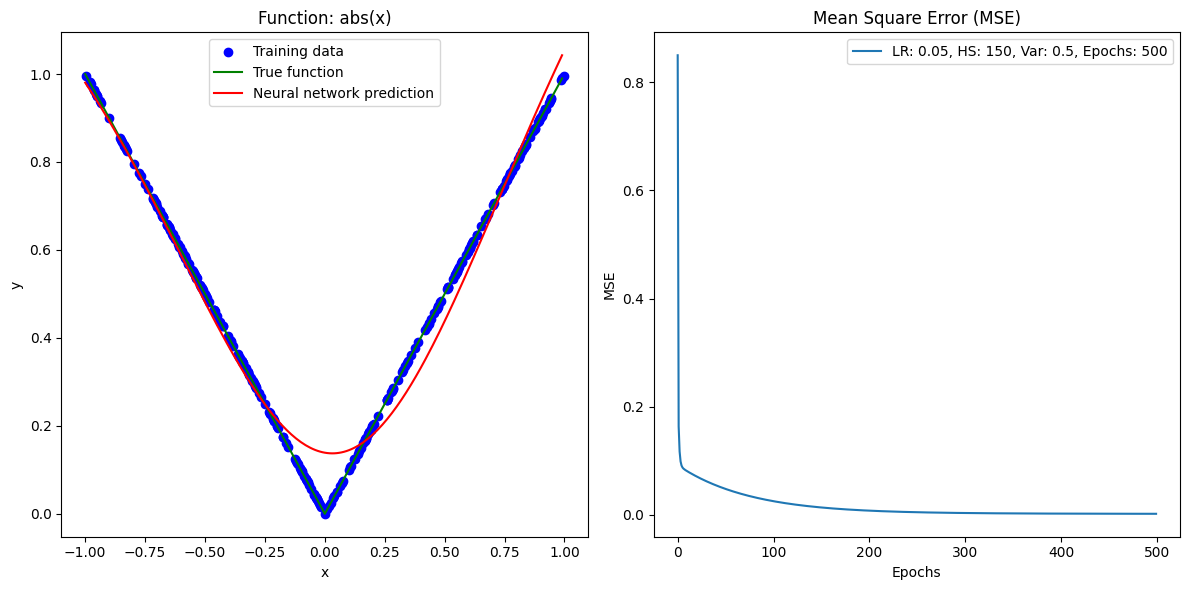

Epoch 0, Loss: 1.6206649868029266
Epoch 100, Loss: 0.057733868127760095
Epoch 200, Loss: 0.04988059321088919
Epoch 300, Loss: 0.04425127733679644
Epoch 400, Loss: 0.04021066972243721


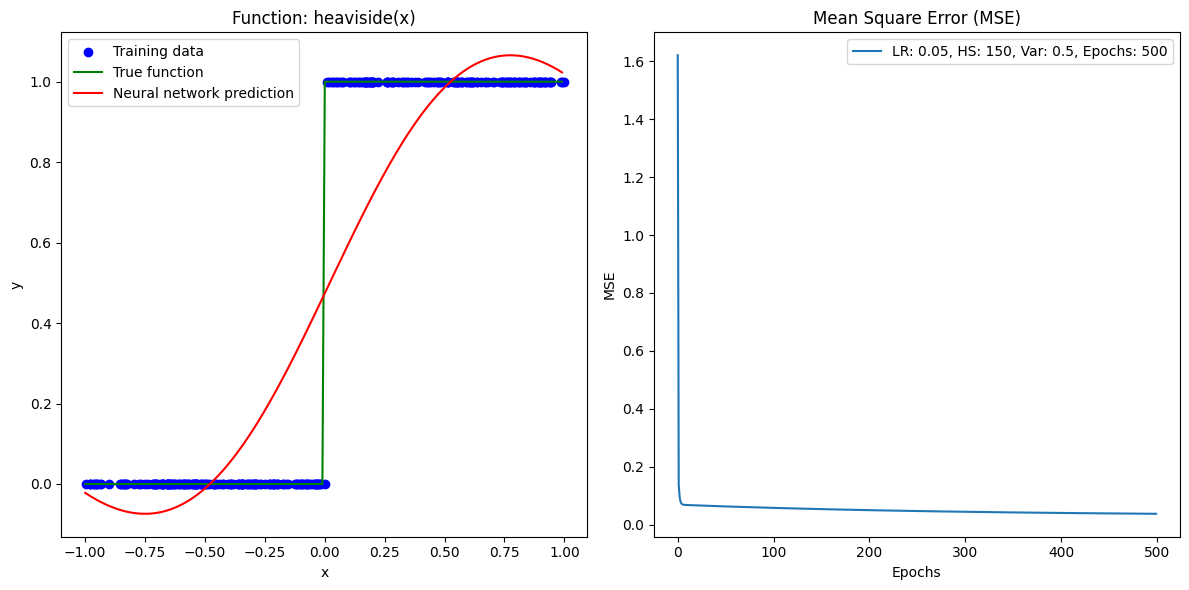

       function  hidden_size  learning_rate  variance  epochs  final_loss
0           x^2          150           0.05       0.5     500    0.001880
1           x^3          150           0.05       0.5     500    0.002928
2        sin(x)          150           0.05       0.5     500    0.312933
3        abs(x)          150           0.05       0.5     500    0.001856
4  heaviside(x)          150           0.05       0.5     500    0.037356


In [14]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the neural network model
class SingleLayerNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate, variance):
        np.random.seed(0)  # For reproducibility
        self.W1 = np.random.normal(0, variance, (hidden_size, input_size))
        self.b1 = np.zeros((hidden_size, 1))
        self.W2 = np.random.normal(0, variance, (output_size, hidden_size))
        self.b2 = np.zeros((output_size, 1))
        self.learning_rate = learning_rate
        self.losses = []

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def forward(self, X):
        self.Z1 = self.W1 @ X.T + self.b1
        self.A1 = self.tanh(self.Z1)
        self.Z2 = self.W2 @ self.A1 + self.b2
        self.A2 = self.Z2  # Linear output
        return self.A2.T

    def backward(self, X, Y, predictions):
        m = X.shape[0]
        dZ2 = (predictions.T - Y.T) / m
        dW2 = dZ2 @ self.A1.T
        db2 = np.sum(dZ2, axis=1, keepdims=True)
        dZ1 = (self.W2.T @ dZ2) * self.tanh_derivative(self.Z1)
        dW1 = dZ1 @ X
        db1 = np.sum(dZ1, axis=1, keepdims=True)

        # Update weights and biases
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X, Y, epochs, early_stopping=False, patience=10):
        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            predictions = self.forward(X)
            loss = np.mean((predictions - Y) ** 2)
            self.losses.append(loss)

            self.backward(X, Y, predictions)

            # Early stopping logic
            if early_stopping:
                if loss < best_loss:
                    best_loss = loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")

# Function to train and graph one function at a time
def train_single_function(func_name, func, hyperparameters):
    # Generate training and test data
    np.random.seed(36)
    N = 300
    X_train = np.random.uniform(-1, 1, (N, 1))
    X_test = np.arange(-1, 1, 0.01).reshape(-1, 1)
    y_train = func(X_train)
    y_test = func(X_test)

    # Extract hyperparameters
    hidden_size = hyperparameters['hidden_size']
    learning_rate = hyperparameters['learning_rate']
    variance = hyperparameters['variance']
    epochs = hyperparameters['epochs']

    # Initialize the neural network
    nn = SingleLayerNeuralNetwork(
        input_size=1,
        hidden_size=hidden_size,
        output_size=1,
        learning_rate=learning_rate,
        variance=variance
    )

    # Train the neural network
    nn.train(X_train, y_train, epochs=epochs, early_stopping=True)

    # Predict on test data
    y_pred = nn.forward(X_test)

    # Plot the results
    plt.figure(figsize=(12, 6))

    # Plot training data, true function, and NN prediction
    plt.subplot(1, 2, 1)
    plt.scatter(X_train, y_train, color='blue', label='Training data')
    plt.plot(X_test, y_test, color='green', label='True function')
    plt.plot(X_test, y_pred, color='red', label='Neural network prediction')
    plt.title(f'Function: {func_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    # Plot the mean square error over epochs
    plt.subplot(1, 2, 2)
    plt.plot(nn.losses, label=f'LR: {learning_rate}, HS: {hidden_size}, Var: {variance}, Epochs: {epochs}')
    plt.legend()
    plt.title('Mean Square Error (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.tight_layout()
    plt.show()

    # Return hyperparameters and final loss
    return {
        'function': func_name,
        'hidden_size': hidden_size,
        'learning_rate': learning_rate,
        'variance': variance,
        'epochs': epochs,
        'final_loss': nn.losses[-1]
    }

# Example usage
functions = {
    'x^2': lambda x: x ** 2,
    'x^3': lambda x: x ** 3,
    'sin(x)': lambda x: np.sin(2 * np.pi * x),
    'abs(x)': lambda x: np.abs(x),
    'heaviside(x)': lambda x: np.heaviside(x, 0)
}

# Set hyperparameters
hyperparameters = {
    'hidden_size': 150,
    'learning_rate': 0.05,
    'variance': 0.5,
    'epochs': 500
}

# Train a single function at a time
results = []
for func_name, func in functions.items():
    result = train_single_function(func_name, func, hyperparameters)
    results.append(result)

# Print recorded hyperparameters and results
results_df = pd.DataFrame(results)
print(results_df)
